# Pierre et le Loup : Environnement Réaliste

Dans notre situation, Pierre pouvait se déplacer presque sans se fatiguer ni avoir faim. Dans un monde plus réaliste, il doit s'asseoir et se reposer de temps en temps, ainsi que se nourrir. Rendons notre monde plus réaliste en appliquant les règles suivantes :

1. En se déplaçant d'un endroit à un autre, Pierre perd de **l'énergie** et accumule de la **fatigue**.
2. Pierre peut récupérer de l'énergie en mangeant des pommes.
3. Pierre peut se débarrasser de la fatigue en se reposant sous un arbre ou sur l'herbe (c'est-à-dire en se rendant sur une case contenant un arbre ou de l'herbe - champ vert).
4. Pierre doit trouver et tuer le loup.
5. Pour tuer le loup, Pierre doit avoir certains niveaux d'énergie et de fatigue, sinon il perd le combat.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

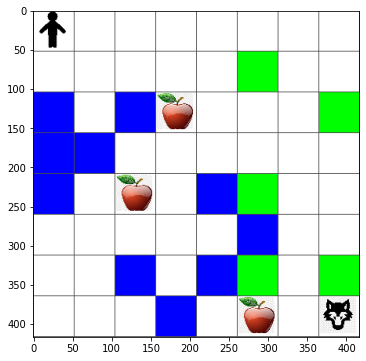

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Définir l'état

Dans nos nouvelles règles du jeu, nous devons suivre l'énergie et la fatigue à chaque état du plateau. Ainsi, nous allons créer un objet `state` qui contiendra toutes les informations nécessaires sur l'état actuel du problème, y compris l'état du plateau, les niveaux actuels d'énergie et de fatigue, et si nous pouvons vaincre le loup lorsque nous sommes dans un état terminal :


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Fonction de Récompense

### Introduction
La fonction de récompense est un élément clé pour entraîner un modèle d'apprentissage par renforcement. Elle guide l'agent en lui attribuant des récompenses basées sur ses actions et leur impact sur l'environnement.

### Objectif
L'objectif principal de la fonction de récompense est d'encourager l'agent à adopter des comportements qui maximisent les résultats souhaités tout en minimisant les actions indésirables.

### Structure
Voici les principaux composants d'une fonction de récompense typique :
- **Récompenses positives** : Elles sont attribuées lorsque l'agent accomplit une tâche ou atteint un objectif.
- **Récompenses négatives** : Elles servent à pénaliser les actions qui mènent à des résultats indésirables.
- **Récompenses neutres** : Elles sont utilisées lorsque l'action de l'agent n'a pas d'impact significatif.

### Exemple
Voici un exemple simple de fonction de récompense :

```python
def reward_function(state, action):
    if action == "move_forward" and state == "clear_path":
        return 10  # Récompense positive
    elif action == "move_forward" and state == "obstacle":
        return -5  # Récompense négative
    else:
        return 0  # Récompense neutre
```

### Bonnes pratiques
- **Définir des objectifs clairs** : Assurez-vous que la fonction de récompense reflète les objectifs globaux du système.
- **Éviter les biais** : Une fonction de récompense mal conçue peut introduire des biais dans le comportement de l'agent.
- **Tester et ajuster** : Testez la fonction de récompense dans différents scénarios et ajustez-la en fonction des résultats.

### Conclusion
Une fonction de récompense bien conçue est essentielle pour garantir que l'agent apprend efficacement et atteint les objectifs souhaités. Prenez le temps de la concevoir soigneusement et de l'adapter en fonction des besoins spécifiques de votre projet.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Algorithme Q-Learning

L'algorithme d'apprentissage reste pratiquement inchangé, nous utilisons simplement `state` au lieu de la position du plateau.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

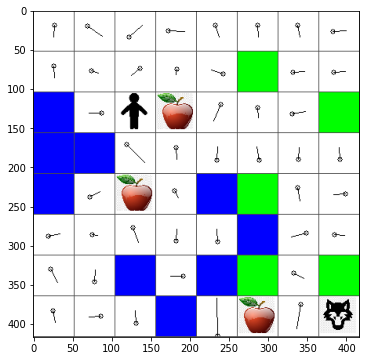

In [11]:
m.plot(Q)

## Résultats

Voyons si nous avons réussi à entraîner Peter à combattre le loup !


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Nous voyons maintenant beaucoup moins de cas de noyade, mais Peter n'est toujours pas toujours capable de tuer le loup. Essayez d'expérimenter et voyez si vous pouvez améliorer ce résultat en jouant avec les hyperparamètres.


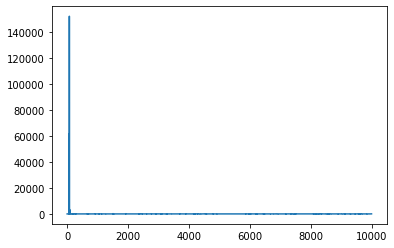

In [13]:
plt.plot(lpath)


---

**Avertissement** :  
Ce document a été traduit à l'aide du service de traduction automatique [Co-op Translator](https://github.com/Azure/co-op-translator). Bien que nous nous efforcions d'assurer l'exactitude, veuillez noter que les traductions automatisées peuvent contenir des erreurs ou des inexactitudes. Le document original dans sa langue d'origine doit être considéré comme la source faisant autorité. Pour des informations critiques, il est recommandé de recourir à une traduction professionnelle réalisée par un humain. Nous déclinons toute responsabilité en cas de malentendus ou d'interprétations erronées résultant de l'utilisation de cette traduction.
